In [1]:
import torch
print(torch.__version__)  # ✅ 정상적으로 실행되면 해결된 것!


2.5.1+cu121


Distribution: Normal Distribution
Data (first 10 values): [ 0.          0.00081058  0.01112531 -0.07469246  0.0080744  -0.01513068
  0.02367572 -0.02622661  0.02053016  0.02491678]
Data Shape: (100,)
--------------------------------------------------
Distribution: AR(1) with phi1=0.5
Data (first 10 values): [ 0.          0.02946208  0.08333509  0.01321429 -0.01759753  0.02240138
  0.00914374  0.03930358 -0.01471381 -0.00908626]
Data Shape: (100,)
--------------------------------------------------
Distribution: AR(1) with phi2=-0.5
Data (first 10 values): [ 0.00000000e+00 -4.26998728e-02  2.98209102e-02 -3.40615265e-02
 -9.87600458e-03  7.74836396e-03  1.00859520e-02 -4.52661978e-02
  3.90686830e-02 -2.15706030e-05]
Data Shape: (100,)
--------------------------------------------------
Distribution: GARCH(1,1) with 5
Data (first 10 values): [ 0.         -0.02073577  0.00752625 -0.05246482  0.00972666  0.00077247
  0.00072181 -0.00705528  0.03123944  0.00377068]
Data Shape: (100,)
-------

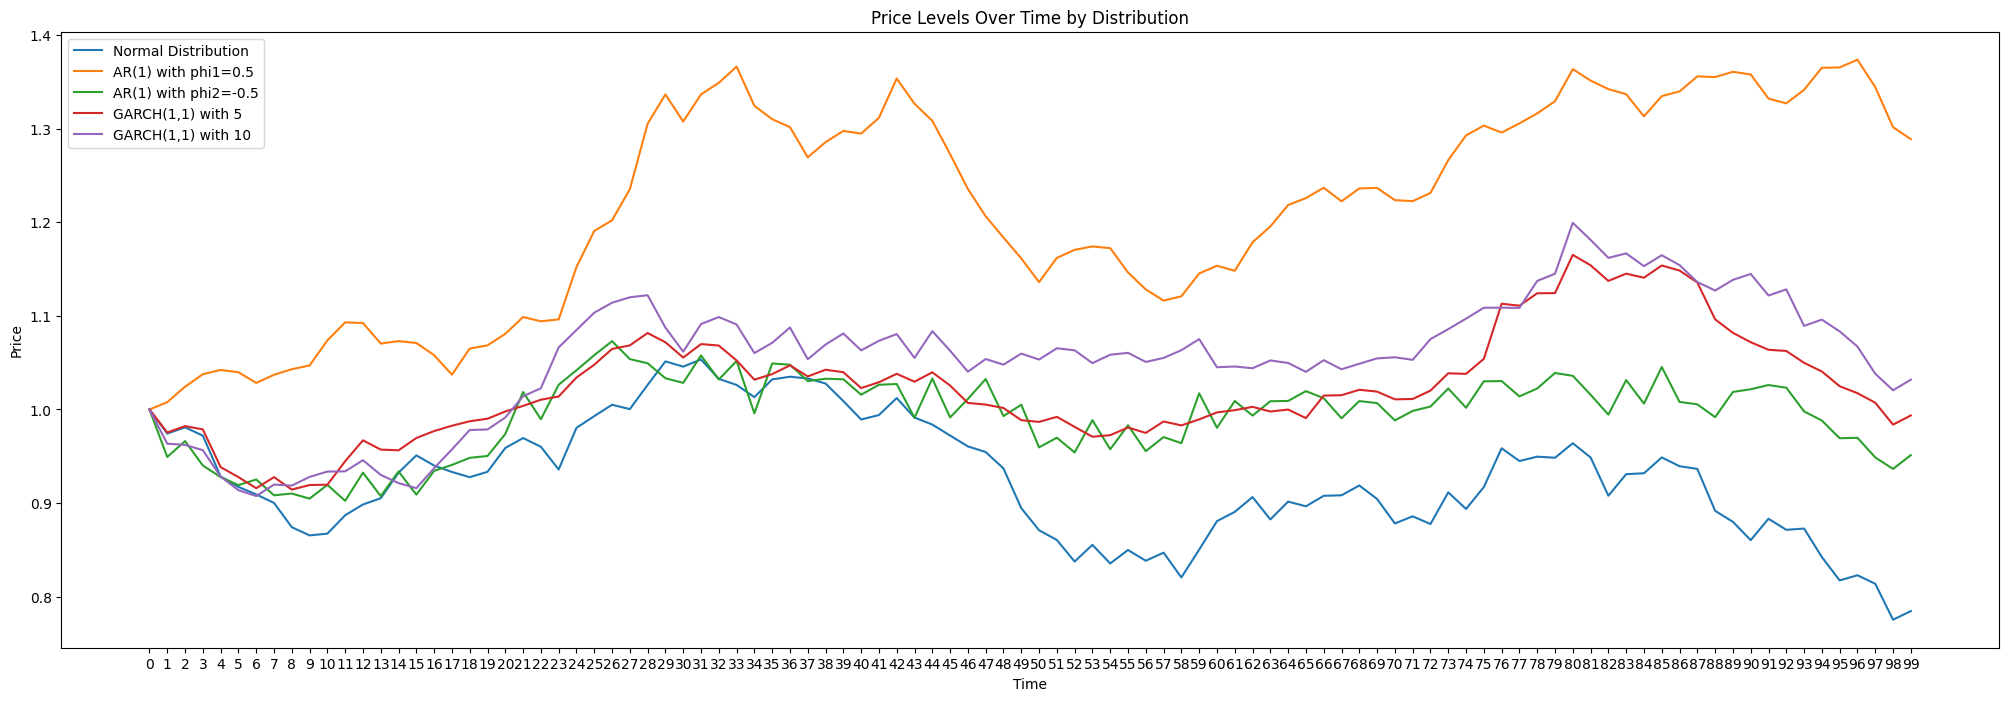

<string>:18: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)


torch.Size([20000, 5, 200])


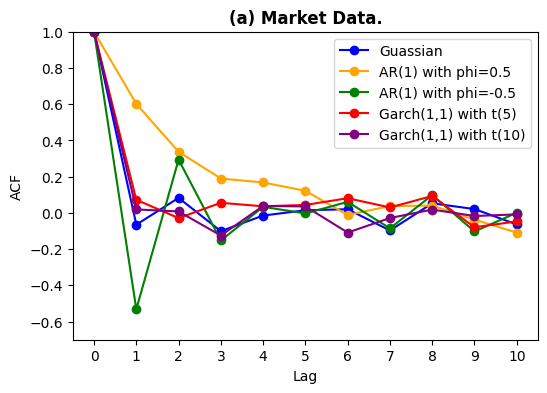

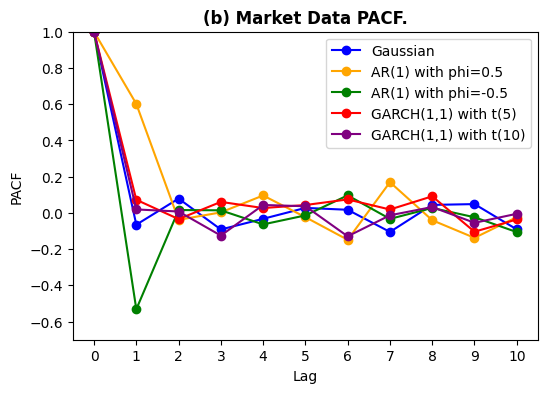

In [2]:
import nbformat

# 실행할 Notebook 파일 이름 (같은 디렉토리에 있어야 함)
notebook_filename = "Dataset_real.ipynb"

# .ipynb 파일 로드
with open(notebook_filename, 'r', encoding="utf-8") as f:
    notebook = nbformat.read(f, as_version=4)

# Notebook의 모든 코드 셀을 실행
for cell in notebook.cells:
    if cell.cell_type == 'code':  # 코드 셀만 실행
        exec(cell.source)


In [3]:
import torch
import numpy as np

# ✅ GPU 사용 설정 (CUDA가 없으면 CPU 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 배치 크기 설정


# 각 배치에 대해 같은 분포에서 새로운 데이터 생성
data_list = []
for _ in range(10000):
    data_dict = generate_synthetic_data_real(T=200, phi1=0.5, phi2=-0.5, nu1=5, nu2=10)
    data_values = list(data_dict.values())  # 리스트로 변환
    data_list.append(data_values)  # 리스트에 추가

# (1000, 5, 100) 형태로 변환 + ✅ GPU로 이동
data_tensor = torch.tensor(data_list, dtype=torch.float32).to(device)  

print(data_tensor.shape)  # 출력: torch.Size([1000, 5, 100])
print(data_tensor.device)  # ✅ 데이터가 GPU에 있는지 확인


torch.Size([10000, 5, 200])
cuda:0


In [4]:
def Inc2Price(data):
    # ✅ GPU에서 실행되도록 `device` 설정
    device = data.device  # data_tensor가 있는 장치 (CPU 또는 GPU)

    # ✅ GPU에서 실행되도록 `torch.Tensor(...)` 수정
    price0 = torch.zeros(data.shape[0], data.shape[1], 1, device=device) + 1  # fill_(1) 대신 +1 사용
    prices_l = torch.cat((price0, data), dim=2)  # GPU에서 실행
    prices_l = torch.cumsum(prices_l, dim=2)  # 누적 합 계산 (GPU에서 실행됨)

    return prices_l

# ✅ GPU에서 실행되도록 보장
prices_l = Inc2Price(data_tensor)

print(prices_l.shape)  # ✅ 올바른 형태 확인
print(prices_l)  # ✅ GPU에서 실행되는지 확인


torch.Size([10000, 5, 201])
tensor([[[1.0000, 1.0000, 0.9603,  ..., 0.5947, 0.5472, 0.5069],
         [1.0000, 1.0000, 1.0095,  ..., 0.8307, 0.8447, 0.7787],
         [1.0000, 1.0000, 0.9615,  ..., 1.0491, 0.9646, 0.9673],
         [1.0000, 1.0000, 0.9759,  ..., 0.9624, 0.9332, 0.9080],
         [1.0000, 1.0000, 0.9704,  ..., 0.8035, 0.7709, 0.7476]],

        [[1.0000, 1.0000, 1.0027,  ..., 0.3929, 0.4153, 0.4280],
         [1.0000, 1.0000, 0.9963,  ..., 1.9050, 1.9164, 1.9343],
         [1.0000, 1.0000, 0.9974,  ..., 0.9863, 1.0337, 1.0189],
         [1.0000, 1.0000, 0.9927,  ..., 0.5196, 0.5384, 0.5249],
         [1.0000, 1.0000, 0.9932,  ..., 0.7433, 0.7452, 0.7097]],

        [[1.0000, 1.0000, 0.9659,  ..., 0.5097, 0.4688, 0.4510],
         [1.0000, 1.0000, 0.9889,  ..., 0.1963, 0.1936, 0.2069],
         [1.0000, 1.0000, 0.9661,  ..., 0.8487, 0.7948, 0.8268],
         [1.0000, 1.0000, 0.9511,  ..., 0.6245, 0.5999, 0.5854],
         [1.0000, 1.0000, 0.9865,  ..., 0.9542, 0.9327, 0.

In [5]:
def StaticPort(prices_l, n_trans=50):
    device = prices_l.device  # ✅ 입력 텐서(prices_l)의 장치를 자동 감지 (CPU 또는 GPU)

    
    num_assets = prices_l.shape[1]  # 5개의 개별 자산

    # ✅ 랜덤 변환 행렬(Transition Matrix) 생성 (GPU에서 실행되도록 수정)
    torch.manual_seed(42)  # 재현 가능성을 위해 시드 설정
    trans_mat = torch.rand(num_assets, n_trans, device=device)  # ✅ GPU에서 생성

    # ✅ 변환 행렬을 배치 크기만큼 확장 (GPU에서 실행)
    broad_trans_mat = trans_mat.unsqueeze(0).repeat(prices_l.size(0), 1, 1)  # (1000, 5, 50)

    # 데이터 차원 변환 (배치, 자산, 시점 순으로 배치)
    swap_prices = prices_l.permute(0, 2, 1)  # (1000, 100, 5)

    # ✅ 모든 데이터 타입을 Float으로 변환 (GPU에서 실행)
    swap_prices = swap_prices.float().to(device)
    broad_trans_mat = broad_trans_mat.float().to(device)

    # ✅ 포트폴리오 변환 (GPU에서 실행)
    swap_trans_prices = torch.bmm(swap_prices, broad_trans_mat)  # (1000, 100, 50)
    port_prices_l = swap_trans_prices.permute(0, 2, 1)  # (1000, 50, 100)

    return port_prices_l

# ✅ GPU에서 실행되도록 보장
port_prices_l = StaticPort(prices_l, n_trans=50)

# ✅ GPU에서 실행되는지 확인
print(port_prices_l.size())  
print(port_prices_l)  # ✅ 'cuda:0'이면 GPU에서 실행 중


torch.Size([10000, 50, 201])
tensor([[[2.4754, 2.4754, 2.4045,  ..., 2.0089, 1.9195, 1.8477],
         [2.9082, 2.9082, 2.8502,  ..., 2.6995, 2.5967, 2.5163],
         [2.8053, 2.8053, 2.7544,  ..., 2.3845, 2.3169, 2.2129],
         ...,
         [3.5831, 3.5831, 3.4954,  ..., 3.0575, 2.9182, 2.8102],
         [2.0513, 2.0513, 1.9890,  ..., 1.9025, 1.8034, 1.7682],
         [1.6184, 1.6184, 1.5834,  ..., 1.2356, 1.1892, 1.1233]],

        [[2.4754, 2.4754, 2.4655,  ..., 1.7382, 1.7761, 1.7445],
         [2.9082, 2.9082, 2.8948,  ..., 3.2122, 3.2806, 3.2576],
         [2.8053, 2.8053, 2.7935,  ..., 2.8422, 2.8892, 2.8783],
         ...,
         [3.5831, 3.5831, 3.5729,  ..., 3.4427, 3.5275, 3.5157],
         [2.0513, 2.0513, 2.0410,  ..., 1.5426, 1.5916, 1.5556],
         [1.6184, 1.6184, 1.6155,  ..., 1.6290, 1.6580, 1.6622]],

        [[2.4754, 2.4754, 2.4044,  ..., 1.7362, 1.6663, 1.6685],
         [2.9082, 2.9082, 2.8271,  ..., 1.8075, 1.7276, 1.7655],
         [2.8053, 2.8053, 2.7

In [6]:
def BuyHold(port_prices_l, Cap):
    device = port_prices_l.device  # ✅ port_prices_l가 있는 장치 확인

    # ✅ Cap을 GPU에서 사용할 수 있도록 변환
    Cap = torch.tensor(Cap, dtype=torch.float32, device=device)  

    # ✅ GPU에서 연산 수행
    BH_money_l = port_prices_l * Cap  # ✅ 포트폴리오 가치 계산 (GPU에서 실행)
    sum_PNL_PORT_BH = BH_money_l[:, :, -1] - BH_money_l[:, :, 0]  # ✅ PNL 계산
    


    return sum_PNL_PORT_BH
    
    
capital = 1.0  # 초기 투자 금액
PNL_PORT_BH = BuyHold(port_prices_l, capital)

# ✅ 정규화된 값 출력
print(PNL_PORT_BH)
print(PNL_PORT_BH.size())


tensor([[-6.2766e-01, -3.9183e-01, -5.9247e-01,  ..., -7.7291e-01,
         -2.8310e-01, -4.9501e-01],
        [-7.3090e-01,  3.4946e-01,  7.2968e-02,  ..., -6.7434e-02,
         -4.9563e-01,  4.3881e-02],
        [-8.0695e-01, -1.1427e+00, -1.3084e+00,  ..., -1.5161e+00,
         -5.2659e-01, -8.0808e-01],
        ...,
        [ 7.4634e-01,  1.2631e+00,  1.2566e+00,  ...,  1.6093e+00,
          5.8651e-01,  8.0212e-01],
        [ 3.7241e-04, -1.0329e-01, -1.1943e-01,  ...,  1.5887e-02,
          4.6038e-02, -3.5120e-02],
        [-1.4330e-01, -1.0873e-01, -5.5788e-02,  ..., -2.4423e-01,
         -1.2243e-01, -1.1371e-01]], device='cuda:0')
torch.Size([10000, 50])


In [7]:
def BuyHold(prices_l, Cap):
    device = prices_l.device  # ✅ prices_l가 위치한 장치를 자동 감지 (CPU 또는 GPU)

    # ✅ Cap을 GPU에서 사용할 수 있도록 변환
    Cap = torch.tensor(Cap, dtype=torch.float32, device=device)  

    # ✅ GPU에서 연산 수행
    BH_money_l = prices_l * Cap  # ✅ 포트폴리오 가치 계산 (GPU에서 실행)
    sum_PNL_BH = BH_money_l[:, :, -1] - BH_money_l[:, :, 0]  # ✅ PNL 계산



    return sum_PNL_BH  # ✅ 정규화된 PNL 반환 (GPU에서 실행됨)

# ✅ 실행 예시 (GPU에서 실행되도록 보장)
capital = 1.0  # 초기 투자 금액
PNL_BH = BuyHold(prices_l, capital)

# ✅ 정규화된 값 출력
print(PNL_BH)
print(PNL_BH.size())


tensor([[-0.4931, -0.2213, -0.0327, -0.0920, -0.2524],
        [-0.5720,  0.9343,  0.0189, -0.4751, -0.2903],
        [-0.5490, -0.7931, -0.1732, -0.4146, -0.0522],
        ...,
        [ 0.4939,  0.7892,  0.3760,  0.3194,  0.0448],
        [ 0.1489, -0.2163,  0.0960,  0.0502, -0.1144],
        [-0.1551,  0.0459, -0.1600,  0.0468, -0.0613]], device='cuda:0')
torch.Size([10000, 5])


In [8]:
import torch

def rolling_mean(prices, window):
    """
    롤링 윈도우 이동 평균을 계산하는 함수
    - prices: 가격 데이터 (batch, assets, time)
    - window: 이동 평균 윈도우 크기
    """
    unfolded = prices.unfold(dimension=2, size=window, step=1)  # (배치, 자산, 시간, 윈도우)
    return unfolded.mean(dim=-1)  # 마지막 차원(윈도우)의 평균 계산

def MeanRev(prices, capital, WH, LR=0.05, SR=0.05):
    """
    Mean Reversion 전략을 수행하여 PNL(수익률) 계산 (롤링 윈도우 적용)
    - prices: 자산 가격 데이터 [배치 크기, 자산 개수, 시간 단계]
    - capital: 초기 투자 금액
    - WH: 이동 평균 윈도우 크기
    - LR: 롱(매수) 비율
    - SR: 숏(매도) 비율
    """

    # ✅ GPU에서 실행되도록 장치 설정
    device = prices.device  # ✅ prices가 위치한 장치를 자동 감지 (CPU 또는 GPU)
    capital = torch.tensor(capital, dtype=torch.float32, device=device)  # 초기 투자금 GPU로 변환

    # ✅ 올바른 이동평균 계산 (롤링 윈도우 방식 적용)
    rolling_mean_values = rolling_mean(prices, WH)

    # ✅ 초반 데이터 부족 구간을 NaN으로 채우기 (이동평균을 계산할 수 없는 부분)
    rolling_mean_values = torch.cat(
        [torch.full((prices.shape[0], prices.shape[1], WH-1), torch.nan, device=device), rolling_mean_values],
        dim=2
    )

    # ✅ 매매 신호 생성 (GPU에서 실행)
    buy_signal = (prices < rolling_mean_values * (1 - LR)).float()  # 가격이 평균보다 낮으면 매수
    sell_signal = (prices > rolling_mean_values * (1 + SR)).float()  # 가격이 평균보다 높으면 매도

    # ✅ 매매 후 수익률 계산 (PNL, GPU에서 실행)
    positions = buy_signal - sell_signal  # 매수(+1), 매도(-1), 유지(0)
    returns = torch.cat((torch.zeros_like(prices[:, :, :1], device=device), 
                         prices[:, :, 1:] - prices[:, :, :-1]), dim=2)

    # ✅ 누적 PNL 계산 (GPU에서 실행)
    pnl = capital * (positions * returns).cumsum(dim=2)



    return pnl[:,:,-1]  # ✅ 정규화된 PNL 반환 (GPU에서 실행됨)

# ✅ 실행 예시 (GPU에서 실행되도록 보장)
capital = 1.0  # 초기 투자 금액
PNL_MR = MeanRev(prices_l, capital, 10, LR=0.05, SR=0.05)

# ✅ 정규화된 값 출력
print(PNL_MR)
print(PNL_MR.size())


tensor([[-2.0471, -2.2763, -0.5517, -0.2087, -0.1661],
        [-1.4682, -1.8523, -0.3836, -0.7012, -0.6871],
        [-1.2596, -2.7642, -0.7582, -1.0352, -0.1364],
        ...,
        [-1.1809, -2.1091, -0.8074, -0.3466, -0.1328],
        [-1.3827, -2.4606, -0.5290, -0.7660, -0.1884],
        [-0.9193, -2.2710, -1.3154, -0.4083, -0.1067]], device='cuda:0')
torch.Size([10000, 5])


In [9]:
import torch

def rolling_mean(prices, window):
    """
    롤링 윈도우 이동 평균을 계산하는 함수
    - prices: 가격 데이터 (batch, assets, time)
    - window: 이동 평균 윈도우 크기
    """
    unfolded = prices.unfold(dimension=2, size=window, step=1)  # (배치, 자산, 시간, 윈도우)
    return unfolded.mean(dim=-1)  # 마지막 차원(윈도우)의 평균 계산

def TrendFollowing(prices, capital, short_window, long_window, LR=0.05, SR=0.05):
    """
    Trend Following 전략을 수행하여 PNL(수익률) 계산 (롤링 윈도우 적용)
    - prices: 자산 가격 데이터 [배치 크기, 자산 개수, 시간 단계]
    - capital: 초기 투자 금액
    - short_window: 단기 이동 평균 윈도우 크기
    - long_window: 장기 이동 평균 윈도우 크기
    - LR: 롱(매수) 비율
    - SR: 숏(매도) 비율
    """

    # ✅ GPU에서 실행되도록 장치 설정
    device = prices.device
    capital = torch.tensor(capital, dtype=torch.float32, device=device)

    # ✅ 올바른 이동평균 계산 (롤링 윈도우 방식 적용)
    short_ma = rolling_mean(prices, short_window)
    long_ma = rolling_mean(prices, long_window)

    # ✅ 초반 데이터 부족 구간을 NaN으로 채우기 (이동평균을 계산할 수 없는 부분)
    short_ma = torch.cat(
        [torch.full((prices.shape[0], prices.shape[1], short_window-1), torch.nan, device=device), short_ma],
        dim=2
    )
    long_ma = torch.cat(
        [torch.full((prices.shape[0], prices.shape[1], long_window-1), torch.nan, device=device), long_ma],
        dim=2
    )

    # ✅ 매매 신호 생성 (GPU에서 실행)
    buy_signal = (short_ma > long_ma).float()  # 단기 평균이 장기 평균을 상향 돌파하면 매수
    sell_signal = (short_ma < long_ma).float()  # 단기 평균이 장기 평균을 하향 돌파하면 매도

    # ✅ 포지션 유지 적용 (이전 포지션 반영)
    positions = torch.zeros_like(prices, device=device)

    for t in range(1, prices.shape[2]):  # 시간 축을 따라 반복
        positions[:, :, t] = positions[:, :, t-1]  # 이전 포지션 유지
        positions[:, :, t] += buy_signal[:, :, t] - sell_signal[:, :, t]  # 매매 반영

    # ✅ 가격 변화율 계산
    returns = torch.cat((torch.zeros_like(prices[:, :, :1], device=device), 
                         prices[:, :, 1:] - prices[:, :, :-1]), dim=2)

    # ✅ 누적 PNL 계산
    pnl = capital * (positions * returns).cumsum(dim=2)



    return pnl[:,:,-1]  # ✅ 정규화된 PNL 반환

# ✅ 실행 예시 (GPU에서 실행되도록 보장)
capital = 1.0  # 초기 투자 금액
PNL_TF = TrendFollowing(prices_l, capital, 5, 10, LR=0.05, SR=0.05)

# ✅ 정규화된 값 출력
print(PNL_TF)
print(PNL_TF.size())


tensor([[ 1.3459, -5.2114, -1.5643, -3.8352,  2.8195],
        [14.5477, 13.9504, -2.5929,  5.6850,  2.5032],
        [-0.9929, -7.8665,  1.6711, -1.5967, -2.6640],
        ...,
        [ 1.7379, -2.1259,  3.6062,  2.3127, -2.0944],
        [-3.3599, -1.1827, -4.6841, -6.8290, -1.9655],
        [-4.9173, -6.4948, -3.0490, -3.8682, -2.5004]], device='cuda:0')
torch.Size([10000, 5])


In [10]:
def merge_PNL(PNL_PORT_BH, PNL_BH, PNL_MR, PNL_RF):
    """
    여러 PNL 벡터를 병합하는 함수
    - PNL_BH, PNL_MR, PNL_RF: 각각의 전략에서 계산된 최종 PNL 값들 [1,5] 형태
    - 반환값: 병합된 PNL 값 [1, 15] 형태
    """

    # ✅ 첫 번째 텐서의 device를 기준으로 모든 텐서를 같은 장치로 이동
    device = PNL_PORT_BH.device
    PNL_l = [PNL_PORT_BH.to(device), PNL_BH.to(device), PNL_MR.to(device), PNL_RF.to(device)]

    # ✅ GPU에서 실행되도록 보장
    PNL_MERGE = torch.cat(PNL_l, dim=1)  # dim=1 방향으로 병합 (열 기준 병합)

    return PNL_MERGE  # ✅ GPU에서 반환

# ✅ GPU에서 실행되도록 보장
merged_PNL = merge_PNL(PNL_PORT_BH, PNL_BH, PNL_MR, PNL_TF)

# ✅ 출력 확인
print(merged_PNL)
print(merged_PNL.size())
 # ✅ 'cuda:0'이면 GPU에서 정상적으로 실행됨


tensor([[-6.2766e-01, -3.9183e-01, -5.9247e-01,  ..., -1.5643e+00,
         -3.8352e+00,  2.8195e+00],
        [-7.3090e-01,  3.4946e-01,  7.2968e-02,  ..., -2.5929e+00,
          5.6850e+00,  2.5032e+00],
        [-8.0695e-01, -1.1427e+00, -1.3084e+00,  ...,  1.6711e+00,
         -1.5967e+00, -2.6640e+00],
        ...,
        [ 7.4634e-01,  1.2631e+00,  1.2566e+00,  ...,  3.6062e+00,
          2.3127e+00, -2.0944e+00],
        [ 3.7241e-04, -1.0329e-01, -1.1943e-01,  ..., -4.6841e+00,
         -6.8290e+00, -1.9655e+00],
        [-1.4330e-01, -1.0873e-01, -5.5788e-02,  ..., -3.0490e+00,
         -3.8682e+00, -2.5004e+00]], device='cuda:0')
torch.Size([10000, 65])


In [11]:
def Compute_PNL(data):
    """
    [1000,5,100] 크기의 데이터를 입력받아 6가지 함수를 적용한 후, 최종 [1000, 65] 크기의 데이터를 출력.

    - data: 원본 데이터셋 (1000, 5, 100)
    - capital: 초기 투자 금액
    - n_trans: 포트폴리오 변환 후 자산 개수 (기본값 50)
    - short_window, long_window: 트렌드 전략의 이동 평균 윈도우
    - WH: 평균 회귀 전략의 이동 평균 윈도우
    """

    # ✅ 입력 데이터 `data`가 위치한 장치를 기준으로 GPU/CPU 설정
    device = data.device  

    # ✅ capital을 GPU에서 사용할 수 있도록 변환
    capital = torch.tensor(1.0, dtype=torch.float32, device=device)  

    # ✅ 하이퍼파라미터 설정
    n_trans = 50
    short_window = 5
    long_window = 10
    WH = 10

    # 1️⃣ 가격 변환 (Inc2Price, GPU에서 실행)
    prices_l = Inc2Price(data).to(device)  # (1000, 5, 101)

    # 2️⃣ 포트폴리오 변환 (StaticPort, GPU에서 실행)
    port_prices_l = StaticPort(prices_l, n_trans=n_trans).to(device)  # (1000, 50, 101)

    # 3️⃣ Buy & Hold 전략 (개별 자산, GPU에서 실행)
    PNL_BH = BuyHold(prices_l, capital).to(device)  # (1000, 5)

    # 4️⃣ Buy & Hold 전략 (포트폴리오 자산, GPU에서 실행)
    PNL_PORT_BH = BuyHold(port_prices_l, capital).to(device)  # (1000, 50)

    # 5️⃣ 평균 회귀 전략 (Mean Reversion, GPU에서 실행)
    PNL_MR = MeanRev(prices_l, capital, WH, LR=0.05, SR=0.05).to(device)  # (1000, 5)

    # 6️⃣ 트렌드 추종 전략 (Trend Following, GPU에서 실행)
    PNL_RF = TrendFollowing(prices_l, capital, short_window, long_window, LR=0.05, SR=0.05).to(device)  # (1000, 5)

    # 7️⃣ 최종 데이터 결합 (GPU에서 실행)
    PNL_final = torch.cat([PNL_BH, PNL_PORT_BH, PNL_MR, PNL_RF], dim=1).to(device)  # (1000, 65)

    return PNL_final  # ✅ GPU에서 반환

# ✅ GPU에서 실행되도록 보장
data_tensor = data_tensor.to("cuda")  # 입력 데이터가 GPU에 있어야 함
PNL_final = Compute_PNL(data_tensor)

# ✅ 출력 확인
print(PNL_final.shape)
print(PNL_final)  # ✅ 'cuda:0'이면 GPU에서 정상적으로 실행됨


torch.Size([10000, 65])
tensor([[-0.4931, -0.2213, -0.0327,  ..., -1.5643, -3.8352,  2.8195],
        [-0.5720,  0.9343,  0.0189,  ..., -2.5929,  5.6850,  2.5032],
        [-0.5490, -0.7931, -0.1732,  ...,  1.6711, -1.5967, -2.6640],
        ...,
        [ 0.4939,  0.7892,  0.3760,  ...,  3.6062,  2.3127, -2.0944],
        [ 0.1489, -0.2163,  0.0960,  ..., -4.6841, -6.8290, -1.9655],
        [-0.1551,  0.0459, -0.1600,  ..., -3.0490, -3.8682, -2.5004]],
       device='cuda:0')


C:\Users\A\AppData\Local\Temp\ipykernel_7956\3022446537.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Cap = torch.tensor(Cap, dtype=torch.float32, device=device)
C:\Users\A\AppData\Local\Temp\ipykernel_7956\431353072.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  capital = torch.tensor(capital, dtype=torch.float32, device=device)  # 초기 투자금 GPU로 변환
C:\Users\A\AppData\Local\Temp\ipykernel_7956\905362697.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  capital = torch.tensor(capital, dtype=torch.float32, device=device)


In [12]:
import torch
import torch.nn as nn
import numpy as np

# ✅ GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. 기본 설정
latent_dim = 1000  # 랜덤 노이즈 차원
R_shape = (5, 200)  # 최종 출력 차원 (PNL 데이터 형식)
output_dim = np.prod(R_shape)  # 5x250 = 1250

# 2. 온도 감소 함수 (Annealing 적용)
def temperature_annealing(step, temp=0.01):
    step_tensor = torch.tensor([2.7183 + step], dtype=torch.float32, device=device)  # ✅ GPU에서도 연산 가능
    return temp / torch.log(step_tensor)

# 3. Generator 정의
class Generator(nn.Module):
    def __init__(self, latent_dim, output_dim):
        super(Generator, self).__init__()

        def block(in_feat, out_feat, normalize=True):
            layers = [nn.Linear(in_feat, out_feat)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_feat, 0.8))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 256, normalize=False),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, output_dim),  # 최종 출력 크기 조정
              # 출력을 [-1,1] 범위로 조정
        )

    def forward(self, z):
        img = self.model(z)
        img = img.view(img.shape[0], *R_shape)  # (batch_size, 5, 250) 형태로 변환
        return img

# 4. 테스트 실행
batch_size = 1000
generator = Generator(latent_dim, output_dim).to(device)  # ✅ 모델을 GPU로 이동
z = torch.randn(batch_size, latent_dim, device=device)  # ✅ 랜덤 노이즈를 GPU에서 생성
generated_data = generator(z)  # ✅ GPU에서 실행되도록 보장

# ✅ 생성된 데이터 출력
print("Generated Data Shape:", generated_data.shape)  # 예상 출력: (1000, 5, 250)
print("Generated Data Device:", generated_data)  # ✅ 'cuda:0'이면 GPU에서 실행됨

# 5. 온도 감소 함수 테스트
for step in range(1, 6):
    print(f"Step {step} - Temperature: {temperature_annealing(step)}")


Generated Data Shape: torch.Size([1000, 5, 200])
Generated Data Device: tensor([[[ 4.9196e-02,  6.1898e-05,  5.7820e-02,  ...,  2.9453e-03,
           1.8997e-04, -8.6108e-03],
         [ 1.3824e-02, -1.9865e-02, -1.7578e-02,  ...,  3.5524e-02,
          -3.3161e-03, -1.9024e-02],
         [ 2.1936e-02, -7.4082e-02,  1.3184e-02,  ...,  4.0601e-02,
          -3.7319e-03,  3.0322e-03],
         [ 9.0449e-03, -5.9732e-02, -3.9848e-02,  ..., -2.6419e-02,
          -3.8907e-03, -3.6766e-03],
         [ 1.0065e-02,  4.5095e-02, -5.4879e-03,  ...,  1.1417e-02,
           1.1569e-02,  3.1032e-02]],

        [[ 1.9744e-02,  4.4587e-02,  8.5925e-03,  ...,  3.5383e-02,
          -6.5479e-02, -8.3862e-02],
         [ 4.0916e-02, -4.3764e-02, -1.3175e-01,  ...,  3.0547e-02,
           9.3918e-02, -1.8651e-02],
         [-9.0379e-03, -4.3311e-02, -2.5082e-02,  ...,  7.7438e-02,
           1.0715e-01,  5.6087e-02],
         [ 1.0353e-02, -4.3392e-02,  3.9213e-02,  ...,  9.4203e-03,
          -2.2493e

In [13]:
def deterministic_NeuralSort(s, tau):
    """
    s: input elements to be sorted. Shape: batch_size x n x 1
    tau: temperature for relaxation. Scalar.
    """
    device = s.device  # ✅ 입력 데이터 `s`가 위치한 장치를 기준으로 GPU/CPU 설정
    n = s.shape[1]  # ✅ n 값 자동 계산 (batch_size, n, 1)

    one = torch.ones((n, 1), dtype=torch.float32, device=device)  # ✅ GPU에서 생성
    A_s = torch.abs(s - s.permute(0, 2, 1)).to(device)  # ✅ GPU 연산 보장
    B = torch.matmul(A_s, torch.matmul(one, one.T)).to(device)  # ✅ GPU 연산
    scaling = (n + 1 - 2 * (torch.arange(n, dtype=torch.float32, device=device) + 1))  # ✅ GPU에서 생성
    C = torch.matmul(s, scaling.unsqueeze(0)).to(device)  # ✅ GPU 연산
    P_max = (C - B).permute(0, 2, 1).to(device)  # ✅ GPU 연산
    sm = torch.nn.Softmax(dim=-1)
    P_hat = sm(P_max / tau)  # ✅ GPU에서 연산 보장

    return P_hat  # ✅ GPU에서 반환



In [14]:
import torch
import torch.nn as nn


class Discriminator(nn.Module):
    def __init__(self, batch_size, W, alphas, project=True):
        super(Discriminator, self).__init__()

        self.W = 10.0  # Weight Factor
        self.project = True  # Project 적용 여부
        self.alphas = [0.05]  # Tail quantile 기준 값들

        # ✅ 모델이 GPU에서 실행될 수 있도록 설정
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

        # 신경망 모델 정의
        self.model = nn.Sequential(
            nn.Linear(1000, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(128, 2 * len(alphas)),  # Tail quantile 관련 출력
        ).to(self.device)  # ✅ 모델을 GPU로 이동

    def project_op(self, validity):
        """
        Project operation 적용하여 validity 변환
        """
        validity = validity.to(self.device)  # ✅ GPU에서 연산 보장
        for i, alpha in enumerate(self.alphas):
            v = validity[:, 2 * i].clone()
            e = validity[:, 2 * i + 1].clone()
            indicator = torch.sign(torch.tensor(0.5 - alpha, device=self.device))

            validity[:, 2 * i] = indicator * (
                (self.W * v < e).float() * v
                + (self.W * v >= e).float() * (v + self.W * e) / (1 + self.W ** 2)
            )
            validity[:, 2 * i + 1] = indicator * (
                (self.W * v < e).float() * e
                + (self.W * v >= e).float() * self.W * (v + self.W * e) / (1 + self.W ** 2)
            )
        return validity

    def forward(self, R):
        R = R.to(self.device)  # ✅ 입력 데이터를 GPU에서 처리
        PNL = Compute_PNL(R).to(self.device)  # ✅ GPU에서 실행 보장
        PNL_transpose = PNL.T.to(self.device)  # ✅ GPU에서 연산 보장
        PNL_s = PNL_transpose.reshape(*PNL_transpose.shape, 1).to(self.device)  # ✅ GPU에서 실행
        perm_matrix = deterministic_NeuralSort(PNL_s, 0.01).to(self.device)  # ✅ GPU에서 실행
        PNL_sort = torch.bmm(perm_matrix, PNL_s).to(self.device)  # ✅ GPU에서 연산
        PNL_validity = self.model(PNL_sort.reshape(*PNL_transpose.shape)).to(self.device)  # ✅ 모델 실행

        if self.project:
            PNL_validity = self.project_op(PNL_validity)  # ✅ GPU에서 실행 보장
        

        return PNL, PNL_validity  # ✅ GPU에서 반환



In [15]:
 
batch_size = 1000
W = 10.0  # 가중치 설정
alphas = [0.05]  # Tail quantile 값들
project = True  # Project 연산 적용 여부

# ✅ Discriminator 객체 생성 (GPU에서 실행되도록 변경)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
discriminator = Discriminator(batch_size, W, alphas, project).to(device)

# ✅ 가짜 R 데이터 생성 (랜덤) + GPU로 이동
R_fake_t = generated_data.to(device)  # (batch_size, 5, 100) 형태의 데이터
print(generated_data.shape)

# ✅ Discriminator 실행 (GPU에서 실행되도록 보장)
PNL_D_t, PNL_validity_D_t = discriminator(R_fake_t)



# ✅ 출력 결과
print("PNL Shape:", PNL_D_t.shape)
print("PNL Validity Shape:", PNL_validity_D_t.shape)



torch.Size([1000, 5, 200])


C:\Users\A\AppData\Local\Temp\ipykernel_7956\3022446537.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Cap = torch.tensor(Cap, dtype=torch.float32, device=device)
C:\Users\A\AppData\Local\Temp\ipykernel_7956\431353072.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  capital = torch.tensor(capital, dtype=torch.float32, device=device)  # 초기 투자금 GPU로 변환
C:\Users\A\AppData\Local\Temp\ipykernel_7956\905362697.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  capital = torch.tensor(capital, dtype=torch.float32, device=device)


PNL Shape: torch.Size([1000, 65])
PNL Validity Shape: torch.Size([65, 2])


In [16]:
def G1(v):
    return v.to(v.device)  # ✅ GPU에서 연산 보장

def G2(e, scale=1):
    return (scale * torch.exp(e / scale)).to(e.device)  # ✅ GPU에서 연산 보장

def G2in(e, scale=1):
    return (scale ** 2 * torch.exp(e / scale)).to(e.device)  # ✅ GPU에서 연산 보장

def G1_quant(v, W=10.0):
    return (- W * v ** 2 / 2).to(v.device)  # ✅ GPU에서 연산 보장

def G2_quant(e, alpha):
    return (alpha * e).to(e.device)  # ✅ GPU에서 연산 보장

def G2in_quant(e, alpha):
    return (alpha * e ** 2 / 2).to(e.device)  # ✅ GPU에서 연산 보장

def S_stats(v, e, X, alpha):
    """
    For a given quantile, here named alpha, calculate the score function value
    """
    device = v.device  # ✅ 입력 데이터 `v`가 위치한 장치를 기준으로 GPU/CPU 설정

    if alpha < 0.5:
        rt = ((X <= v).float() - alpha).to(device) * (G1(v) - G1(X)) + \
             (1. / alpha * G2(e)).to(device) * (X <= v).float().to(device) * (v - X) + \
             G2(e).to(device) * (e - v) - G2in(e)
    else:
        alpha_inverse = 1 - alpha
        rt = ((X >= v).float() - alpha_inverse).to(device) * (G1(X) - G1(v)) + \
             (1. / alpha_inverse * G2(-e)).to(device) * (X >= v).float().to(device) * (X - v) + \
             G2(-e).to(device) * (v - e) - G2in(-e)
    
    return torch.mean(rt).to(device)  # ✅ GPU에서 반환

'''
alpha=0.05이므로 if문 수식만 사용
'''
def S_quant(v, e, X, alpha, W=10.0):
    """
    For a given quantile, here named alpha, calculate the score function value
    """
    device = v.device  # ✅ 입력 데이터 `v`가 위치한 장치를 기준으로 GPU/CPU 설정

    if alpha < 0.5:
        rt = ((X <= v).float() - alpha).to(device) * (G1_quant(v, W) - G1_quant(X, W)) + \
             (1. / alpha * G2_quant(e, alpha)).to(device) * (X <= v).float().to(device) * (v - X) + \
             G2_quant(e, alpha).to(device) * (e - v) - G2in_quant(e, alpha)
    else:
        alpha_inverse = 1 - alpha
        rt = ((X >= v).float() - alpha_inverse).to(device) * (G1_quant(v, W) - G1_quant(X, W)) + \
             (1. / alpha_inverse * G2_quant(-e, alpha_inverse)).to(device) * (X >= v).float().to(device) * (X - v) + \
             G2_quant(-e, alpha_inverse).to(device) * (v - e) - G2in_quant(-e, alpha_inverse)
    
    return torch.mean(rt).to(device)  # ✅ GPU에서 반환


In [17]:
import torch
import torch.nn as nn

class Score(nn.Module):
    def __init__(self):
        super(Score, self).__init__()
        self.alphas = [0.05]
        self.score_name = 'quant'
        self.score_alpha = S_quant  # ✅ GPU에서 실행되도록 설정

    def forward(self, PNL_validity, PNL):
        """
        PNL_validity: (batch_size, 2 * num_alphas) - 신경망의 출력값
        PNL: (batch_size, num_assets) - 포트폴리오 손익 데이터
        """
        device = PNL_validity.device  # ✅ 입력 데이터의 장치를 기준으로 GPU/CPU 설정
        loss = torch.tensor(0.0, device=device)  # ✅ GPU에서 연산되도록 초기값 설정

        for i, alpha in enumerate(self.alphas):
            PNL_var = PNL_validity[:, [2 * i]].to(device)  # ✅ GPU에서 연산되도록 보장
            PNL_es = PNL_validity[:, [2 * i + 1]].to(device)  # ✅ GPU에서 연산되도록 보장
            loss += self.score_alpha(PNL_var, PNL_es, PNL.T.to(device), alpha).to(device)  # ✅ GPU에서 실행

        return loss  # ✅ GPU에서 반환




In [ ]:
'''# ✅ Score 모델을 GPU에서 실행되도록 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
score = Score().to(device)

# ✅ 예제 데이터 생성 (GPU에서 실행되도록 변환)
PNL_fake_t, PNL_validity_fake_t = discriminator.forward(R_fake_t.to(device))

# ✅ Score 함수 실행 (GPU에서 실행되도록 보장)
loss = score(PNL_validity_fake_t.to(device), PNL_fake_t.to(device))

# ✅ 출력 확인
print("Score (Loss):", loss.item())  # 최종 손실 값 출력
print("Loss Device:", loss.device)  # ✅ 'cuda:0'이면 GPU에서 실행됨'''


C:\Users\A\AppData\Local\Temp\ipykernel_8388\3771129627.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Cap = torch.tensor(Cap, dtype=torch.float32, device=device)
C:\Users\A\AppData\Local\Temp\ipykernel_8388\1371711499.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  capital = torch.tensor(capital, dtype=torch.float32, device=device)  # 초기 투자금 GPU로 변환
C:\Users\A\AppData\Local\Temp\ipykernel_8388\65590733.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  capital = torch.tensor(capital, dtype=torch.float32, device=device)


Score (Loss): 0.3793685734272003
Loss Device: cuda:0


In [ ]:
'''# ✅ Score 모델을 GPU에서 실행되도록 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
score = Score().to(device)

# ✅ 예제 데이터 생성 (GPU에서 실행되도록 변환)
PNL_t, PNL_validity_t = discriminator.forward(data_tensor_t.to(device))

# ✅ Score 함수 실행 (GPU에서 실행되도록 보장)
loss = score(PNL_validity_t.to(device), PNL_t.to(device))

# ✅ 출력 확인
print("Score (Loss):", loss.item())  # 최종 손실 값 출력
print("Loss Device:", loss.device)  # ✅ 'cuda:0'이면 GPU에서 실행됨'''


C:\Users\A\AppData\Local\Temp\ipykernel_8388\3771129627.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Cap = torch.tensor(Cap, dtype=torch.float32, device=device)
C:\Users\A\AppData\Local\Temp\ipykernel_8388\1371711499.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  capital = torch.tensor(capital, dtype=torch.float32, device=device)  # 초기 투자금 GPU로 변환
C:\Users\A\AppData\Local\Temp\ipykernel_8388\65590733.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  capital = torch.tensor(capital, dtype=torch.float32, device=device)


Score (Loss): 0.6966728568077087
Loss Device: cuda:0


In [18]:
import time
import torch
import numpy as np
from torch.autograd import Variable


def Train_GAN(dataloader, generator, discriminator, criterion, latent_dim, model_index, seed, n_epochs=11000, batch_size=1000):
    """
    GAN 훈련 함수 (Discriminator와 Generator가 5번마다 학습하도록 조정)
    """

    start_time = time.time()
    torch.manual_seed(seed)

    # ✅ GPU 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)

    # ✅ 학습률 조정 (Generator 학습률 증가, Discriminator 학습률 감소)
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-6, betas=(0.5, 0.999))  # 기존 1e-6 → 1e-4
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=1e-7, betas=(0.5, 0.999))  # 기존 1e-7 → 1e-8

    
    loss_d_l = []
    loss_g_l = []

    for epoch in range(n_epochs):
        epoch_loss_D = []
        epoch_loss_G = []


        
        
        for i, R in enumerate(dataloader):

            # ✅ Convert input data to tensor (GPU에서 실행되도록 보장)
            real_R = Variable(R[0].to(device))

            # ✅ Generate noise as generator input (GPU에서 실행되도록 변환)
            t_dist = torch.distributions.StudentT(df=5)  # 자유도 5인 t-분포 정의
            z = Variable(t_dist.sample((batch_size, latent_dim)).to(device))

            

            # ✅ Generate fake data
            gen_R = generator(z)

            # ---------------------
            #  Train Discriminator (D)
            # ---------------------
            if i % 1 == 0:  # ✅ Discriminator도 5번마다 학습
                optimizer_D.zero_grad()

                # ✅ Compute real and fake PNL
                PNL_real, PNL_validity_real = discriminator(real_R)
                PNL_fake, PNL_validity_fake = discriminator(gen_R.detach())  # ✅ detach() 사용하여 Generator 그래디언트 방지

                # ✅ Compute Discriminator loss (GPU에서 연산 보장)
                real_score = criterion(PNL_validity_real, PNL_real).to(device)
                fake_score = criterion(PNL_validity_fake, PNL_real).to(device)
                loss_D = real_score - fake_score

                # ✅ Update Discriminator
                loss_D.backward(retain_graph=True)
                optimizer_D.step()
                epoch_loss_D.append(loss_D.item())

            # -----------------
            #  Train Generator (G)
            # -----------------
            if i % 1 == 0:  # ✅ Generator도 5번마다 학습
                optimizer_G.zero_grad()

                # ✅ Compute Generator loss (GPU에서 연산 보장)
                gen_PNL, gen_PNL_validity = discriminator(gen_R)
                loss_G = criterion(gen_PNL_validity, PNL_real).to(device)

                # ✅ Update Generator
                loss_G.backward()
                optimizer_G.step()
                epoch_loss_G.append(loss_G.item())

        # Store losses for logging
        loss_d_l.append(np.mean(epoch_loss_D))
        loss_g_l.append(np.mean(epoch_loss_G))


        if epoch % 100 == 0:
            print(f"[Epoch {epoch}] [D loss: {np.mean(epoch_loss_D):.4f}] [G loss: {np.mean(epoch_loss_G):.4f}]")
            print(f"--- {int(time.time() - start_time)} seconds passed ---")


        if epoch % 1000 == 0:
            z_intermediate = Variable(torch.randn(batch_size, latent_dim, device=device))  # 랜덤 노이즈 생성
            intermediate_fake_data = generator(z_intermediate).detach().cpu().numpy()  # Generator의 가짜 데이터 생성

            loss_dge_intermediate = np.stack([np.array(loss_d_l), np.array(loss_g_l)])
    
            np.save(f'loss_dge_epoch_{epoch}.npy', loss_dge_intermediate)  # Save intermediate loss data
            torch.save(intermediate_fake_data, f"final_fake_data_epoch_{epoch}.pt")   # Save intermediate generated fake data

            print(f"✅ [Epoch {epoch}] Intermediate Loss and Fake Data saved successfully.")



    z_final = Variable(torch.randn(batch_size, latent_dim, device=device))  # 랜덤 노이즈 생성
    final_fake_data = generator(z_final).detach().cpu().numpy()  # Generator의 가짜 데이터 생성
    
    # Save Loss Values
    loss_dge = np.stack([np.array(loss_d_l), np.array(loss_g_l)])
    
    np.save('loss_dge_0214.npy', loss_dge)  # Save loss data
    torch.save(final_fake_data, "final_fake_data_0214.pt")   # Save generated fake data

    torch.save(generator.state_dict(), "generator_trained_0214.pth")
    torch.save(discriminator.state_dict(), "discriminator_trained_0214.pth")

# ✅ 옵티마이저 상태 저장
    torch.save(optimizer_G.state_dict(), "optimizer_G_0214.pth")
    torch.save(optimizer_D.state_dict(), "optimizer_D_0214.pth")


    print("✅ Loss and Fake Data saved successfully.")
    
    return loss_dge, final_fake_data
   

In [19]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# ✅ GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ 데이터셋 & DataLoader (GPU 최적화)
real_data = data_tensor.to(device)
dataset = TensorDataset(real_data)
batch_size = 1000  # 
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True if device == "cuda" else False)

# ✅ 모델 & 손실 함수 초기화 (GPU에서 실행되도록 설정)
latent_dim = 1000  # 랜덤 노이즈 차원
R_shape = (5, 200)  # 최종 출력 차원 (PNL 데이터 형식)
output_dim_tailgan = np.prod(R_shape) 

generator = Generator(latent_dim=1000, output_dim=output_dim_tailgan).to(device)
discriminator = Discriminator(batch_size=batch_size, W=10.0, alphas=[0.05]).to(device)
criterion = Score().to(device)

# ✅ Train_GAN 실행
loss_history, generated_data = Train_GAN(
    dataloader=dataloader,
    generator=generator,
    discriminator=discriminator,
    criterion=criterion,
    latent_dim=1000,
    model_index=0,
    seed=42,
    n_epochs=11000,
    batch_size=batch_size  # 
)

# ✅ 실행 완료 후 확인
print("GAN Training Completed!")

C:\Users\A\AppData\Local\Temp\ipykernel_7956\3022446537.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Cap = torch.tensor(Cap, dtype=torch.float32, device=device)
C:\Users\A\AppData\Local\Temp\ipykernel_7956\431353072.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  capital = torch.tensor(capital, dtype=torch.float32, device=device)  # 초기 투자금 GPU로 변환
C:\Users\A\AppData\Local\Temp\ipykernel_7956\905362697.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  capital = torch.tensor(capital, dtype=torch.float32, device=device)


[Epoch 0] [D loss: -0.1511] [G loss: 6.6117]
--- 8 seconds passed ---
✅ [Epoch 0] Intermediate Loss and Fake Data saved successfully.
[Epoch 100] [D loss: -0.1804] [G loss: 6.6682]
--- 696 seconds passed ---
[Epoch 200] [D loss: -0.1066] [G loss: 6.7241]
--- 1382 seconds passed ---
[Epoch 300] [D loss: -0.1580] [G loss: 6.7820]
--- 2069 seconds passed ---
[Epoch 400] [D loss: -0.1508] [G loss: 6.7349]
--- 2756 seconds passed ---
[Epoch 500] [D loss: -0.2071] [G loss: 6.8264]
--- 3443 seconds passed ---
[Epoch 600] [D loss: -0.1492] [G loss: 6.8591]
--- 4130 seconds passed ---
[Epoch 700] [D loss: -0.0904] [G loss: 6.8646]
--- 4816 seconds passed ---
[Epoch 800] [D loss: -0.0663] [G loss: 6.7882]
--- 5503 seconds passed ---
[Epoch 900] [D loss: -0.0740] [G loss: 6.6640]
--- 6189 seconds passed ---
[Epoch 1000] [D loss: -0.1060] [G loss: 6.5543]
--- 6876 seconds passed ---
✅ [Epoch 1000] Intermediate Loss and Fake Data saved successfully.
[Epoch 1100] [D loss: -0.1476] [G loss: 6.4920]
-

학습된 함수를 다시 학습시킬 때 훈련하는 코드 
(OPTIMIZER 부분 잘 보고 다시 코드 돌려보기기)

In [21]:
import time
import torch
import numpy as np
from torch.autograd import Variable


def Train_GAN(dataloader, generator, discriminator, criterion, latent_dim, model_index, seed, n_epochs=135000, batch_size=1000):
    """
    GAN 훈련 함수 (Discriminator와 Generator가 5번마다 학습하도록 조정)
    """

    start_time = time.time()
    torch.manual_seed(seed)

    # ✅ GPU 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)



    # ✅ 학습률 조정 (Generator 학습률 증가, Discriminator 학습률 감소)
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-6, betas=(0.5, 0.999))  # 기존 1e-6 → 1e-4
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=1e-7, betas=(0.5, 0.999))  # 기존 1e-7 → 1e-8

    optimizer_G.load_state_dict(torch.load("optimizer_G_0214.pth"))
    optimizer_D.load_state_dict(torch.load("optimizer_D_0214.pth"))
    
    print("✅ 모델 및 옵티마이저 로드 완료!")
    
    loss_d_l = []
    loss_g_l = []

    for epoch in range(n_epochs):
        epoch_loss_D = []
        epoch_loss_G = []
        
        
        

        for i, R in enumerate(dataloader):

            # ✅ Convert input data to tensor (GPU에서 실행되도록 보장)
            real_R = Variable(R[0].to(device))

            # ✅ Generate noise as generator input (GPU에서 실행되도록 변환)
            t_dist = torch.distributions.StudentT(df=5)  # 자유도 5인 t-분포 정의
            z = Variable(t_dist.sample((batch_size, latent_dim)).to(device))

            

            # ✅ Generate fake data
            gen_R = generator(z)

            # ---------------------
            #  Train Discriminator (D)
            # ---------------------
            if i % 1 == 0:  # ✅ Discriminator도 5번마다 학습
                optimizer_D.zero_grad()

                # ✅ Compute real and fake PNL
                PNL_real, PNL_validity_real = discriminator(real_R)
                PNL_fake, PNL_validity_fake = discriminator(gen_R.detach())  # ✅ detach() 사용하여 Generator 그래디언트 방지

                # ✅ Compute Discriminator loss (GPU에서 연산 보장)
                real_score = criterion(PNL_validity_real, PNL_real).to(device)
                fake_score = criterion(PNL_validity_fake, PNL_real).to(device)
                loss_D = real_score - fake_score

                # ✅ Update Discriminator
                loss_D.backward(retain_graph=True)
                optimizer_D.step()
                epoch_loss_D.append(loss_D.item())

            # -----------------
            #  Train Generator (G)
            # -----------------
            if i % 1 == 0:  # ✅ Generator도 5번마다 학습
                optimizer_G.zero_grad()

                # ✅ Compute Generator loss (GPU에서 연산 보장)
                gen_PNL, gen_PNL_validity = discriminator(gen_R)
                loss_G = criterion(gen_PNL_validity, PNL_real).to(device)

                # ✅ Update Generator
                loss_G.backward()
                optimizer_G.step()
                epoch_loss_G.append(loss_G.item())

        # Store losses for logging
        loss_d_l.append(np.mean(epoch_loss_D))
        loss_g_l.append(np.mean(epoch_loss_G))


        if epoch % 100 == 0:
            print(f"[Epoch {epoch}] [D loss: {np.mean(epoch_loss_D):.4f}] [G loss: {np.mean(epoch_loss_G):.4f}]")
            print(f"--- {int(time.time() - start_time)} seconds passed ---")


        if epoch % 1000 == 0:
            z_intermediate = Variable(torch.randn(batch_size, latent_dim, device=device))  # 랜덤 노이즈 생성
            intermediate_fake_data = generator(z_intermediate).detach().cpu().numpy()  # Generator의 가짜 데이터 생성

            loss_dge_intermediate = np.stack([np.array(loss_d_l), np.array(loss_g_l)])
    
            np.save(f'loss_dge_epoch_0215_{epoch}.npy', loss_dge_intermediate)  # Save intermediate loss data
            torch.save(intermediate_fake_data, f"final_fake_data_epoch_0215_{epoch}.pt")   # Save intermediate generated fake data

            print(f"✅ [Epoch {epoch}] Intermediate Loss and Fake Data saved successfully.")

    z_final = Variable(torch.randn(batch_size, latent_dim, device=device))  # 랜덤 노이즈 생성
    final_fake_data = generator(z_final).detach().cpu().numpy()  # Generator의 가짜 데이터 생성
    
    # Save Loss Values
    loss_dge = np.stack([np.array(loss_d_l), np.array(loss_g_l)])
    
    np.save('loss_dge_0215.npy', loss_dge)  # Save loss data
    torch.save(final_fake_data, "final_fake_data_0215.pt")   # Save generated fake data

    torch.save(generator.state_dict(), "generator_trained_0215.pth")
    torch.save(discriminator.state_dict(), "discriminator_trained_0215.pth")

# ✅ 옵티마이저 상태 저장
    torch.save(optimizer_G.state_dict(), "optimizer_G_0215.pth")
    torch.save(optimizer_D.state_dict(), "optimizer_D_0215.pth")


    print("✅ Loss and Fake Data saved successfully.")
    
    return loss_dge, final_fake_data
   

In [22]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# ✅ GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ 데이터셋 & DataLoader (GPU 최적화)
real_data = data_tensor.to(device)
dataset = TensorDataset(real_data)
batch_size = 1000  # 
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True if device == "cuda" else False)

# ✅ 모델 & 손실 함수 초기화 (GPU에서 실행되도록 설정)
latent_dim = 1000  # 랜덤 노이즈 차원
R_shape = (5, 200)  # 최종 출력 차원 (PNL 데이터 형식)
output_dim_tailgan = np.prod(R_shape) 

generator = Generator(latent_dim=1000, output_dim=output_dim_tailgan).to(device)
discriminator = Discriminator(batch_size=batch_size, W=10.0, alphas=[0.05]).to(device)
generator.load_state_dict(torch.load("generator_trained_0214.pth"))
discriminator.load_state_dict(torch.load("discriminator_trained_0214.pth"))
criterion = Score().to(device)

# ✅ Train_GAN 실행
loss_history, generated_data = Train_GAN(
    dataloader=dataloader,
    generator=generator,
    discriminator=discriminator,
    criterion=criterion,
    latent_dim=1000,
    model_index=0,
    seed=42,
    n_epochs=13500,
    batch_size=batch_size  # 
)

# ✅ 실행 완료 후 확인
print("GAN Training Completed!")

C:\Users\A\AppData\Local\Temp\ipykernel_7956\1545840905.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator_trained_0214.pth

✅ 모델 및 옵티마이저 로드 완료!
[Epoch 0] [D loss: -0.0076] [G loss: 5.9050]
--- 8 seconds passed ---
✅ [Epoch 0] Intermediate Loss and Fake Data saved successfully.
[Epoch 100] [D loss: -0.0062] [G loss: 5.9345]
--- 808 seconds passed ---
[Epoch 200] [D loss: -0.0035] [G loss: 5.9352]
--- 1602 seconds passed ---
[Epoch 300] [D loss: -0.0017] [G loss: 5.9263]
--- 2400 seconds passed ---
[Epoch 400] [D loss: -0.0017] [G loss: 5.9120]
--- 3198 seconds passed ---
[Epoch 500] [D loss: -0.0039] [G loss: 5.8994]
--- 3995 seconds passed ---
[Epoch 600] [D loss: -0.0089] [G loss: 5.8796]
--- 4793 seconds passed ---
[Epoch 700] [D loss: -0.0119] [G loss: 5.8722]
--- 5590 seconds passed ---
[Epoch 800] [D loss: -0.0118] [G loss: 5.9253]
--- 6388 seconds passed ---
[Epoch 900] [D loss: -0.0118] [G loss: 5.9192]
--- 7185 seconds passed ---
[Epoch 1000] [D loss: -0.0175] [G loss: 5.8998]
--- 7983 seconds passed ---
✅ [Epoch 1000] Intermediate Loss and Fake Data saved successfully.
[Epoch 1100] [D loss: -0.0101

In [23]:
import time
import torch
import numpy as np
from torch.autograd import Variable


def Train_GAN(dataloader, generator, discriminator, criterion, latent_dim, model_index, seed, n_epochs=135000, batch_size=1000):
    """
    GAN 훈련 함수 (Discriminator와 Generator가 5번마다 학습하도록 조정)
    """

    start_time = time.time()
    torch.manual_seed(seed)

    # ✅ GPU 설정
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    generator.to(device)
    discriminator.to(device)



    # ✅ 학습률 조정 (Generator 학습률 증가, Discriminator 학습률 감소)
    optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-6, betas=(0.5, 0.999))  # 기존 1e-6 → 1e-4
    optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=1e-7, betas=(0.5, 0.999))  # 기존 1e-7 → 1e-8

    optimizer_G.load_state_dict(torch.load("optimizer_G_0215.pth"))
    optimizer_D.load_state_dict(torch.load("optimizer_D_0215.pth"))
    
    print("✅ 모델 및 옵티마이저 로드 완료!")
    
    loss_d_l = []
    loss_g_l = []

    for epoch in range(n_epochs):
        epoch_loss_D = []
        epoch_loss_G = []
        
        
        

        for i, R in enumerate(dataloader):

            # ✅ Convert input data to tensor (GPU에서 실행되도록 보장)
            real_R = Variable(R[0].to(device))

            # ✅ Generate noise as generator input (GPU에서 실행되도록 변환)
            t_dist = torch.distributions.StudentT(df=5)  # 자유도 5인 t-분포 정의
            z = Variable(t_dist.sample((batch_size, latent_dim)).to(device))

            

            # ✅ Generate fake data
            gen_R = generator(z)

            # ---------------------
            #  Train Discriminator (D)
            # ---------------------
            if i % 1 == 0:  # ✅ Discriminator도 5번마다 학습
                optimizer_D.zero_grad()

                # ✅ Compute real and fake PNL
                PNL_real, PNL_validity_real = discriminator(real_R)
                PNL_fake, PNL_validity_fake = discriminator(gen_R.detach())  # ✅ detach() 사용하여 Generator 그래디언트 방지

                # ✅ Compute Discriminator loss (GPU에서 연산 보장)
                real_score = criterion(PNL_validity_real, PNL_real).to(device)
                fake_score = criterion(PNL_validity_fake, PNL_real).to(device)
                loss_D = real_score - fake_score

                # ✅ Update Discriminator
                loss_D.backward(retain_graph=True)
                optimizer_D.step()
                epoch_loss_D.append(loss_D.item())

            # -----------------
            #  Train Generator (G)
            # -----------------
            if i % 1 == 0:  # ✅ Generator도 5번마다 학습
                optimizer_G.zero_grad()

                # ✅ Compute Generator loss (GPU에서 연산 보장)
                gen_PNL, gen_PNL_validity = discriminator(gen_R)
                loss_G = criterion(gen_PNL_validity, PNL_real).to(device)

                # ✅ Update Generator
                loss_G.backward()
                optimizer_G.step()
                epoch_loss_G.append(loss_G.item())

        # Store losses for logging
        loss_d_l.append(np.mean(epoch_loss_D))
        loss_g_l.append(np.mean(epoch_loss_G))


        if epoch % 100 == 0:
            print(f"[Epoch {epoch}] [D loss: {np.mean(epoch_loss_D):.4f}] [G loss: {np.mean(epoch_loss_G):.4f}]")
            print(f"--- {int(time.time() - start_time)} seconds passed ---")


        if epoch % 1000 == 0:
            z_intermediate = Variable(torch.randn(batch_size, latent_dim, device=device))  # 랜덤 노이즈 생성
            intermediate_fake_data = generator(z_intermediate).detach().cpu().numpy()  # Generator의 가짜 데이터 생성

            loss_dge_intermediate = np.stack([np.array(loss_d_l), np.array(loss_g_l)])
    
            np.save(f'loss_dge_epoch_0217_{epoch}.npy', loss_dge_intermediate)  # Save intermediate loss data
            torch.save(intermediate_fake_data, f"final_fake_data_epoch_0217_{epoch}.pt")   # Save intermediate generated fake data

            print(f"✅ [Epoch {epoch}] Intermediate Loss and Fake Data saved successfully.")

    z_final = Variable(torch.randn(batch_size, latent_dim, device=device))  # 랜덤 노이즈 생성
    final_fake_data = generator(z_final).detach().cpu().numpy()  # Generator의 가짜 데이터 생성
    
    # Save Loss Values
    loss_dge = np.stack([np.array(loss_d_l), np.array(loss_g_l)])
    
    np.save('loss_dge_0217.npy', loss_dge)  # Save loss data
    torch.save(final_fake_data, "final_fake_data_0217.pt")   # Save generated fake data

    torch.save(generator.state_dict(), "generator_trained_0217.pth")
    torch.save(discriminator.state_dict(), "discriminator_trained_0217.pth")

# ✅ 옵티마이저 상태 저장
    torch.save(optimizer_G.state_dict(), "optimizer_G_0217.pth")
    torch.save(optimizer_D.state_dict(), "optimizer_D_0217.pth")


    print("✅ Loss and Fake Data saved successfully.")
    
    return loss_dge, final_fake_data
   

In [24]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# ✅ GPU 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ 데이터셋 & DataLoader (GPU 최적화)
real_data = data_tensor.to(device)
dataset = TensorDataset(real_data)
batch_size = 1000  # 
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=True if device == "cuda" else False)

# ✅ 모델 & 손실 함수 초기화 (GPU에서 실행되도록 설정)
latent_dim = 1000  # 랜덤 노이즈 차원
R_shape = (5, 200)  # 최종 출력 차원 (PNL 데이터 형식)
output_dim_tailgan = np.prod(R_shape) 

generator = Generator(latent_dim=1000, output_dim=output_dim_tailgan).to(device)
discriminator = Discriminator(batch_size=batch_size, W=10.0, alphas=[0.05]).to(device)
generator.load_state_dict(torch.load("generator_trained_0215.pth"))
discriminator.load_state_dict(torch.load("discriminator_trained_0215.pth"))
criterion = Score().to(device)

# ✅ Train_GAN 실행
loss_history, generated_data = Train_GAN(
    dataloader=dataloader,
    generator=generator,
    discriminator=discriminator,
    criterion=criterion,
    latent_dim=1000,
    model_index=0,
    seed=42,
    n_epochs=9000,
    batch_size=batch_size  # 
)

# ✅ 실행 완료 후 확인
print("GAN Training Completed!")

C:\Users\A\AppData\Local\Temp\ipykernel_7956\1273633898.py:20: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  generator.load_state_dict(torch.load("generator_trained_0215.pth

✅ 모델 및 옵티마이저 로드 완료!


C:\Users\A\AppData\Local\Temp\ipykernel_7956\3022446537.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Cap = torch.tensor(Cap, dtype=torch.float32, device=device)
C:\Users\A\AppData\Local\Temp\ipykernel_7956\431353072.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  capital = torch.tensor(capital, dtype=torch.float32, device=device)  # 초기 투자금 GPU로 변환
C:\Users\A\AppData\Local\Temp\ipykernel_7956\905362697.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  capital = torch.tensor(capital, dtype=torch.float32, device=device)


[Epoch 0] [D loss: 0.0014] [G loss: 5.9880]
--- 9 seconds passed ---
✅ [Epoch 0] Intermediate Loss and Fake Data saved successfully.
[Epoch 100] [D loss: 0.0004] [G loss: 6.0502]
--- 867 seconds passed ---
[Epoch 200] [D loss: 0.0023] [G loss: 6.1019]
--- 1733 seconds passed ---
[Epoch 300] [D loss: 0.0016] [G loss: 6.0850]
--- 2595 seconds passed ---
[Epoch 400] [D loss: 0.0007] [G loss: 6.0164]
--- 3452 seconds passed ---
[Epoch 500] [D loss: 0.0006] [G loss: 5.9804]
--- 4308 seconds passed ---
[Epoch 600] [D loss: 0.0014] [G loss: 5.9990]
--- 5194 seconds passed ---
[Epoch 700] [D loss: 0.0007] [G loss: 6.0511]
--- 6087 seconds passed ---
[Epoch 800] [D loss: 0.0024] [G loss: 6.0760]
--- 6980 seconds passed ---
[Epoch 900] [D loss: -0.0003] [G loss: 6.0504]
--- 7879 seconds passed ---
[Epoch 1000] [D loss: 0.0024] [G loss: 6.0499]
--- 8769 seconds passed ---
✅ [Epoch 1000] Intermediate Loss and Fake Data saved successfully.
[Epoch 1100] [D loss: 0.0013] [G loss: 6.0743]
--- 9670 sec